In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.5 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=b8d77e71e21e5097a34794eed90589d1427179d8d852ce10c05cb8b82852a9ec
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=6461f5e18d7dcfc512573cc41640c8085656718915b4788a4dbe661ff4b77e5c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import os
import gc 
import cv2
import random

from tqdm.auto import tqdm
import torch.nn.functional as F
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

In [3]:
# def seed_everything(seed=100):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
# seed_everything()

In [4]:
# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 100
LR = 1e-4    
IMG_SIZE = 192
BATCH_SIZE = 16

In [5]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/Train")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/train_labels")
train_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/Train",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/train_labels",x),masks)})
print(train_df.shape)
del images, masks
train_df.head()

(126, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/Tr...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/tr...


In [6]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val_labels")
val_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/val_labels",x),masks)})
print(val_df.shape)
del images, masks
val_df.head()

(40, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/va...


In [7]:
images=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test")
masks=os.listdir("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test_labels")
test_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/cleaned-nr206/Cleaned_DataSet/test_labels",x),masks)})
print(test_df.shape)
del images, masks
test_df.head()

(40, 2)


,images,masks
0,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
1,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
2,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
3,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...
4,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...,/kaggle/input/cleaned-nr206/Cleaned_DataSet/te...


In [8]:
def encode_labels(masks):
    labelencoder = LabelEncoder()
    masks_reshaped = masks.reshape(-1)
    masks_encoded = labelencoder.fit_transform(masks_reshaped)
    del masks_reshaped, labelencoder
    return masks_encoded.reshape(masks.shape)

In [9]:
# Create a custom dataset class
classes=9
class SegmentationDataset(Dataset):
    def __init__(self, df):
        self.df = df
        images=[]
        masks=[]
        for idx in range(len(self.df)):
            sample = self.df.iloc[idx]
            images.append(load_img(sample.images, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE)))
            masks.append(load_img(sample.masks, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE)))
#             images.append(cv2.resize(cv2.imread(sample.images, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)))
#             masks.append(cv2.resize(cv2.imread(sample.masks, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE)))
        images = np.array(images)
        masks = np.array(masks)
        n_classes = classes #len(np.unique(masks))
        masks_encoded = encode_labels(masks)
        self.masks_cat = to_categorical(masks_encoded, num_classes=n_classes)
        self.images = np.expand_dims(images, axis=-1) / 255.0
        del masks_encoded, images, masks, n_classes
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = torch.from_numpy(np.transpose(self.images[idx],(2, 0, 1))).float()
        mask = torch.from_numpy(np.transpose(self.masks_cat[idx],(2, 0, 1))).float()
        return image, mask

In [10]:
# Processed train and validation sets
train_data = SegmentationDataset(train_df)
val_data = SegmentationDataset(val_df)
test_data = SegmentationDataset(test_df)

In [11]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 126
Size of Validset : 40


In [12]:
from torch.utils.data import DataLoader

In [13]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_data, batch_size=1, shuffle=False)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 8
Total number of batches in Val Loader: 3


In [14]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([16, 1, 192, 192])
Size of one batch of masks: torch.Size([16, 9, 192, 192])


In [15]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss

In [16]:
def dice_score(y_true, y_pred):
    return 1.0-DiceLoss(mode="binary")(y_true, y_pred)
            
def jac_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-15) / (union + 1e-15)

In [17]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [18]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x, masks):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        loss = DiceLoss(mode='binary')(logits, masks)
        score = dice_score(logits, masks)
        return logits, loss, score

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [19]:
model = UNet(n_channels=1, n_classes=classes)
model.to(DEVICE);

In [20]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    total_score = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss, score = model(images, masks)
        loss.backward()
        optimizer.step()
        total_score += score.item()
        total_loss += loss.item()

    return total_loss / len(data_loader), total_score / len(data_loader)

In [21]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    total_score = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            logits, loss, score = model(images, masks)

            total_score += score.item()
            total_loss += loss.item()

        return total_loss / len(data_loader), total_score / len(data_loader)

In [22]:
# Define the optimizer 
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

In [23]:
gc.collect()

0

In [24]:
# Training and evaluation loop
best_val_loss = 1e9
writer=SummaryWriter("DiceLoss_Clean_Dataset")
for i in range(EPOCHS):
    train_loss, train_score = train_model(trainloader, model, optimizer)
    val_loss, val_score = eval_model(valloader, model)

    if val_loss < best_val_loss:
        print("MODEL SAVED")
        
        best_val_loss = val_loss
    writer.add_scalar("Loss/train", train_loss, i)
    writer.add_scalar("Loss/val", val_loss, i)
    writer.add_scalar("Score/train", train_score, i)
    writer.add_scalar("Score/val", val_score, i)
    writer.flush()
    print(f"\033[1m\033[92m Epoch {i} Train DiceLoss {train_loss} Val DiceLoss {val_loss} Train dice_score {train_score} Val dice_score {val_score}")
writer.close()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 0 Train DiceLoss 0.7428395673632622 Val DiceLoss 0.796937088171641 Train dice_score 0.2571604326367378 Val dice_score 0.20306291182835898


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 1 Train DiceLoss 0.7028221189975739 Val DiceLoss 0.7813854416211446 Train dice_score 0.29717788100242615 Val dice_score 0.21861455837885538


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 2 Train DiceLoss 0.6880005076527596 Val DiceLoss 0.7558150490125021 Train dice_score 0.31199949234724045 Val dice_score 0.24418495098749796


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 3 Train DiceLoss 0.6772798299789429 Val DiceLoss 0.7361286083857218 Train dice_score 0.32272017002105713 Val dice_score 0.26387139161427814


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 4 Train DiceLoss 0.6690030544996262 Val DiceLoss 0.7159260312716166 Train dice_score 0.33099694550037384 Val dice_score 0.28407396872838336


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 5 Train DiceLoss 0.6613242328166962 Val DiceLoss 0.6909013390541077 Train dice_score 0.33867576718330383 Val dice_score 0.30909866094589233


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 6 Train DiceLoss 0.6542882025241852 Val DiceLoss 0.6623536944389343 Train dice_score 0.3457117974758148 Val dice_score 0.3376463055610657


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 7 Train DiceLoss 0.6476854532957077 Val DiceLoss 0.6490935881932577 Train dice_score 0.3523145467042923 Val dice_score 0.35090641180674237


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 8 Train DiceLoss 0.6411967128515244 Val DiceLoss 0.6393279433250427 Train dice_score 0.35880328714847565 Val dice_score 0.3606720566749573


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 9 Train DiceLoss 0.6350830644369125 Val DiceLoss 0.6379886468251547 Train dice_score 0.36491693556308746 Val dice_score 0.3620113531748454


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 10 Train DiceLoss 0.6288407817482948 Val DiceLoss 0.626908004283905 Train dice_score 0.37115921825170517 Val dice_score 0.37309199571609497


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 11 Train DiceLoss 0.6228848397731781 Val DiceLoss 0.6161561409632365 Train dice_score 0.3771151602268219 Val dice_score 0.3838438590367635


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 12 Train DiceLoss 0.617120549082756 Val DiceLoss 0.6156019369761149 Train dice_score 0.38287945091724396 Val dice_score 0.3843980630238851


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 13 Train DiceLoss 0.6112439036369324 Val DiceLoss 0.6074910163879395 Train dice_score 0.3887560963630676 Val dice_score 0.39250898361206055


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 14 Train DiceLoss 0.605497919023037 Val DiceLoss 0.5973847309748331 Train dice_score 0.39450208097696304 Val dice_score 0.4026152690251668


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 15 Train DiceLoss 0.5998139381408691 Val DiceLoss 0.5980416536331177 Train dice_score 0.40018606185913086 Val dice_score 0.4019583463668823


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 16 Train DiceLoss 0.5943340882658958 Val DiceLoss 0.5914198954900106 Train dice_score 0.40566591173410416 Val dice_score 0.40858010450998944


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 17 Train DiceLoss 0.5886142551898956 Val DiceLoss 0.5827947854995728 Train dice_score 0.41138574481010437 Val dice_score 0.41720521450042725


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 18 Train DiceLoss 0.5827684253454208 Val DiceLoss 0.5782917340596517 Train dice_score 0.41723157465457916 Val dice_score 0.4217082659403483


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 19 Train DiceLoss 0.5768222287297249 Val DiceLoss 0.5725545684496561 Train dice_score 0.4231777712702751 Val dice_score 0.4274454315503438


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 20 Train DiceLoss 0.5707796290516853 Val DiceLoss 0.5658425490061442 Train dice_score 0.42922037094831467 Val dice_score 0.4341574509938558


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 21 Train DiceLoss 0.5653392300009727 Val DiceLoss 0.5641638239224752 Train dice_score 0.43466076999902725 Val dice_score 0.43583617607752484


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 22 Train DiceLoss 0.5592603608965874 Val DiceLoss 0.5589190721511841 Train dice_score 0.44073963910341263 Val dice_score 0.4410809278488159


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 23 Train DiceLoss 0.5531715601682663 Val DiceLoss 0.5462112426757812 Train dice_score 0.4468284398317337 Val dice_score 0.45378875732421875


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 24 Train DiceLoss 0.5474293380975723 Val DiceLoss 0.5427295168240865 Train dice_score 0.4525706619024277 Val dice_score 0.4572704831759135


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 25 Train DiceLoss 0.540749192237854 Val DiceLoss 0.5362990697224935 Train dice_score 0.459250807762146 Val dice_score 0.46370093027750653


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 26 Train DiceLoss 0.5347041115164757 Val DiceLoss 0.5281962553660074 Train dice_score 0.4652958884835243 Val dice_score 0.4718037446339925


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 27 Train DiceLoss 0.5281605646014214 Val DiceLoss 0.5211991469065348 Train dice_score 0.47183943539857864 Val dice_score 0.47880085309346515


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 28 Train DiceLoss 0.5220663249492645 Val DiceLoss 0.5235934654871622 Train dice_score 0.4779336750507355 Val dice_score 0.4764065345128377


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 29 Train DiceLoss 0.5163340792059898 Val DiceLoss 0.5138970812161764 Train dice_score 0.48366592079401016 Val dice_score 0.48610291878382367


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 30 Train DiceLoss 0.5093049108982086 Val DiceLoss 0.5062272747357687 Train dice_score 0.4906950891017914 Val dice_score 0.4937727252642314


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 31 Train DiceLoss 0.5030665919184685 Val DiceLoss 0.5035315354665121 Train dice_score 0.4969334080815315 Val dice_score 0.496468464533488


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 32 Train DiceLoss 0.4968210756778717 Val DiceLoss 0.4950726826985677 Train dice_score 0.5031789243221283 Val dice_score 0.5049273173014323


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 33 Train DiceLoss 0.49071042984724045 Val DiceLoss 0.48564157883326214 Train dice_score 0.5092895701527596 Val dice_score 0.5143584211667379


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 34 Train DiceLoss 0.48407647013664246 Val DiceLoss 0.479119877020518 Train dice_score 0.5159235298633575 Val dice_score 0.520880122979482


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 35 Train DiceLoss 0.47763876616954803 Val DiceLoss 0.47134987513224286 Train dice_score 0.522361233830452 Val dice_score 0.5286501248677572


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 36 Train DiceLoss 0.4714605361223221 Val DiceLoss 0.4707822601000468 Train dice_score 0.5285394638776779 Val dice_score 0.5292177398999532


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 37 Train DiceLoss 0.46482260525226593 Val DiceLoss 0.4621968666712443 Train dice_score 0.5351773947477341 Val dice_score 0.5378031333287557


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 38 Train DiceLoss 0.4584722965955734 Val DiceLoss 0.45766274134318036 Train dice_score 0.5415277034044266 Val dice_score 0.5423372586568197


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 39 Train DiceLoss 0.4518202990293503 Val DiceLoss 0.45053017139434814 Train dice_score 0.5481797009706497 Val dice_score 0.5494698286056519


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 40 Train DiceLoss 0.4452661797404289 Val DiceLoss 0.44068851073582965 Train dice_score 0.5547338202595711 Val dice_score 0.5593114892641703


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 41 Train DiceLoss 0.4389502704143524 Val DiceLoss 0.43975236018498737 Train dice_score 0.5610497295856476 Val dice_score 0.5602476398150126


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 42 Train DiceLoss 0.4320225268602371 Val DiceLoss 0.4303911526997884 Train dice_score 0.5679774731397629 Val dice_score 0.5696088473002116


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 43 Train DiceLoss 0.4257763847708702 Val DiceLoss 0.4150148232777913 Train dice_score 0.5742236152291298 Val dice_score 0.5849851767222086


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 44 Train DiceLoss 0.4270748570561409 Val DiceLoss 0.9037525256474813 Train dice_score 0.5729251429438591 Val dice_score 0.09624747435251872


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 45 Train DiceLoss 0.41954851150512695 Val DiceLoss 0.42067062854766846 Train dice_score 0.580451488494873 Val dice_score 0.5793293714523315


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 46 Train DiceLoss 0.4073590040206909 Val DiceLoss 0.40953638156255084 Train dice_score 0.5926409959793091 Val dice_score 0.5904636184374491


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 47 Train DiceLoss 0.4006611779332161 Val DiceLoss 0.40096427996953327 Train dice_score 0.5993388220667839 Val dice_score 0.5990357200304667


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 48 Train DiceLoss 0.39426274597644806 Val DiceLoss 0.3928792675336202 Train dice_score 0.6057372540235519 Val dice_score 0.6071207324663798


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 49 Train DiceLoss 0.38809317350387573 Val DiceLoss 0.3906385103861491 Train dice_score 0.6119068264961243 Val dice_score 0.609361489613851


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 50 Train DiceLoss 0.3820418566465378 Val DiceLoss 0.3740711808204651 Train dice_score 0.6179581433534622 Val dice_score 0.6259288191795349


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 51 Train DiceLoss 0.37584415823221207 Val DiceLoss 0.3719279368718465 Train dice_score 0.6241558417677879 Val dice_score 0.6280720631281534


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 52 Train DiceLoss 0.3697770684957504 Val DiceLoss 0.36251362164815265 Train dice_score 0.6302229315042496 Val dice_score 0.6374863783518473


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 53 Train DiceLoss 0.3638075515627861 Val DiceLoss 0.36651668945948285 Train dice_score 0.6361924484372139 Val dice_score 0.6334833105405172


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 54 Train DiceLoss 0.3579588755965233 Val DiceLoss 0.36030113697052 Train dice_score 0.6420411244034767 Val dice_score 0.63969886302948


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 55 Train DiceLoss 0.35181791335344315 Val DiceLoss 0.3515223264694214 Train dice_score 0.6481820866465569 Val dice_score 0.6484776735305786


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 56 Train DiceLoss 0.3456294760107994 Val DiceLoss 0.3411520520846049 Train dice_score 0.6543705239892006 Val dice_score 0.6588479479153951


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 57 Train DiceLoss 0.3404661640524864 Val DiceLoss 0.33866719404856366 Train dice_score 0.6595338359475136 Val dice_score 0.6613328059514364


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 58 Train DiceLoss 0.33375822752714157 Val DiceLoss 0.33246052265167236 Train dice_score 0.6662417724728584 Val dice_score 0.6675394773483276


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 59 Train DiceLoss 0.3283815383911133 Val DiceLoss 0.31886953115463257 Train dice_score 0.6716184616088867 Val dice_score 0.6811304688453674


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 60 Train DiceLoss 0.32237306237220764 Val DiceLoss 0.3156425555547078 Train dice_score 0.6776269376277924 Val dice_score 0.6843574444452921


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 61 Train DiceLoss 0.3170412927865982 Val DiceLoss 0.30913305282592773 Train dice_score 0.6829587072134018 Val dice_score 0.6908669471740723


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 62 Train DiceLoss 0.31123390793800354 Val DiceLoss 0.30800557136535645 Train dice_score 0.6887660920619965 Val dice_score 0.6919944286346436


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 63 Train DiceLoss 0.30620836466550827 Val DiceLoss 0.2978896697362264 Train dice_score 0.6937916353344917 Val dice_score 0.7021103302637736


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 64 Train DiceLoss 0.30096936970949173 Val DiceLoss 0.29491257667541504 Train dice_score 0.6990306302905083 Val dice_score 0.705087423324585


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 65 Train DiceLoss 0.29565367847681046 Val DiceLoss 0.2908124128977458 Train dice_score 0.7043463215231895 Val dice_score 0.7091875871022543


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 66 Train DiceLoss 0.2905338481068611 Val DiceLoss 0.28395940860112506 Train dice_score 0.7094661518931389 Val dice_score 0.7160405913988749


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 67 Train DiceLoss 0.28536487370729446 Val DiceLoss 0.28308536609013873 Train dice_score 0.7146351262927055 Val dice_score 0.7169146339098612


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 68 Train DiceLoss 0.28027671575546265 Val DiceLoss 0.2745767633120219 Train dice_score 0.7197232842445374 Val dice_score 0.7254232366879781


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 69 Train DiceLoss 0.27580544352531433 Val DiceLoss 0.27451570828755695 Train dice_score 0.7241945564746857 Val dice_score 0.725484291712443


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 70 Train DiceLoss 0.2709850147366524 Val DiceLoss 0.27196204662323 Train dice_score 0.7290149852633476 Val dice_score 0.72803795337677


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 71 Train DiceLoss 0.265922911465168 Val DiceLoss 0.2603151202201843 Train dice_score 0.734077088534832 Val dice_score 0.7396848797798157


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 72 Train DiceLoss 0.26117808371782303 Val DiceLoss 0.25980710983276367 Train dice_score 0.738821916282177 Val dice_score 0.7401928901672363


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 73 Train DiceLoss 0.2568342760205269 Val DiceLoss 0.25540071725845337 Train dice_score 0.7431657239794731 Val dice_score 0.7445992827415466


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 74 Train DiceLoss 0.2519250363111496 Val DiceLoss 0.24567445119222006 Train dice_score 0.7480749636888504 Val dice_score 0.7543255488077799


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 75 Train DiceLoss 0.2472371757030487 Val DiceLoss 0.24467535813649496 Train dice_score 0.7527628242969513 Val dice_score 0.755324641863505


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 76 Train DiceLoss 0.24309170246124268 Val DiceLoss 0.2410664955774943 Train dice_score 0.7569082975387573 Val dice_score 0.7589335044225057


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 77 Train DiceLoss 0.23855239152908325 Val DiceLoss 0.24190847078959146 Train dice_score 0.7614476084709167 Val dice_score 0.7580915292104086


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 78 Train DiceLoss 0.23468782007694244 Val DiceLoss 0.2294211983680725 Train dice_score 0.7653121799230576 Val dice_score 0.7705788016319275


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 79 Train DiceLoss 0.2307586818933487 Val DiceLoss 0.228779137134552 Train dice_score 0.7692413181066513 Val dice_score 0.771220862865448


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 80 Train DiceLoss 0.22612234205007553 Val DiceLoss 0.22817579905192056 Train dice_score 0.7738776579499245 Val dice_score 0.7718242009480795


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 81 Train DiceLoss 0.2236558124423027 Val DiceLoss 0.276245375474294 Train dice_score 0.7763441875576973 Val dice_score 0.7237546245257059


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 82 Train DiceLoss 0.22092841565608978 Val DiceLoss 0.2268439531326294 Train dice_score 0.7790715843439102 Val dice_score 0.7731560468673706


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 83 Train DiceLoss 0.21405243128538132 Val DiceLoss 0.21623794237772623 Train dice_score 0.7859475687146187 Val dice_score 0.7837620576222738


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 84 Train DiceLoss 0.209928996860981 Val DiceLoss 0.21139140923817953 Train dice_score 0.790071003139019 Val dice_score 0.7886085907618204


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 85 Train DiceLoss 0.20597545057535172 Val DiceLoss 0.20400049289067587 Train dice_score 0.7940245494246483 Val dice_score 0.7959995071093241


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 86 Train DiceLoss 0.2026110291481018 Val DiceLoss 0.20728896061579385 Train dice_score 0.7973889708518982 Val dice_score 0.7927110393842062


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 87 Train DiceLoss 0.19905026257038116 Val DiceLoss 0.19616961479187012 Train dice_score 0.8009497374296188 Val dice_score 0.8038303852081299


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 88 Train DiceLoss 0.19496459513902664 Val DiceLoss 0.19458431005477905 Train dice_score 0.8050354048609734 Val dice_score 0.805415689945221


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 89 Train DiceLoss 0.19169817864894867 Val DiceLoss 0.20979740222295126 Train dice_score 0.8083018213510513 Val dice_score 0.7902025977770487


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 90 Train DiceLoss 0.18853475153446198 Val DiceLoss 0.18659975131352743 Train dice_score 0.811465248465538 Val dice_score 0.8134002486864725


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 91 Train DiceLoss 0.18494585156440735 Val DiceLoss 0.18097092707951865 Train dice_score 0.8150541484355927 Val dice_score 0.8190290729204813


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 92 Train DiceLoss 0.18148842453956604 Val DiceLoss 0.18057789405186972 Train dice_score 0.818511575460434 Val dice_score 0.8194221059481303


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 93 Train DiceLoss 0.1785709485411644 Val DiceLoss 0.17753815650939941 Train dice_score 0.8214290514588356 Val dice_score 0.8224618434906006


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 94 Train DiceLoss 0.17471352219581604 Val DiceLoss 0.16846583286921182 Train dice_score 0.825286477804184 Val dice_score 0.8315341671307882


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 95 Train DiceLoss 0.17204920947551727 Val DiceLoss 0.17567183574040732 Train dice_score 0.8279507905244827 Val dice_score 0.8243281642595927


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 96 Train DiceLoss 0.16861581057310104 Val DiceLoss 0.1677876114845276 Train dice_score 0.831384189426899 Val dice_score 0.8322123885154724


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 97 Train DiceLoss 0.1653922125697136 Val DiceLoss 0.16005158424377441 Train dice_score 0.8346077874302864 Val dice_score 0.8399484157562256


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 98 Train DiceLoss 0.16263001412153244 Val DiceLoss 0.1644735336303711 Train dice_score 0.8373699858784676 Val dice_score 0.8355264663696289


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 Epoch 99 Train DiceLoss 0.15982062369585037 Val DiceLoss 0.1623138189315796 Train dice_score 0.8401793763041496 Val dice_score 0.8376861810684204


In [25]:
torch.save(model.state_dict(), 'best_DiceLoss_Clean_model_SD.pt')
torch.save(model, 'best_DiceLoss_Clean_model.pt')

In [26]:
original=[]
imgs=[]
pred=[]
model=model.eval()
with torch.no_grad():
    for images, masks in tqdm(testloader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        logits, loss, score = model(images, masks)
        mask=logits[0].cpu().detach().numpy()
        predicted_masks=np.transpose(mask.squeeze(),(1,2,0))
        predicted_labels = np.argmax(predicted_masks, axis=-1)
        
        image_gt=images[0].squeeze().cpu().detach().numpy()
        
        mask_gt=masks[0].cpu().detach().numpy()
        predicted_masks_gt=np.transpose(mask_gt.squeeze(),(1,2,0))
        predicted_labels_gt = np.argmax(predicted_masks_gt, axis=-1)
        original.append(predicted_labels_gt)
        pred.append(predicted_labels)
        imgs.append(image_gt)
        del images,masks,logits, loss, score,mask, predicted_masks, predicted_labels, mask_gt, predicted_masks_gt, predicted_labels_gt

  0%|          | 0/40 [00:00<?, ?it/s]

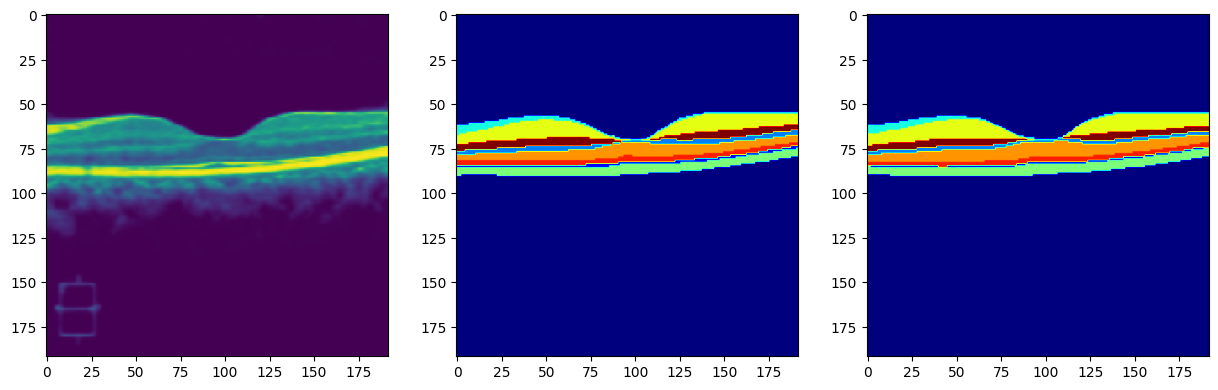

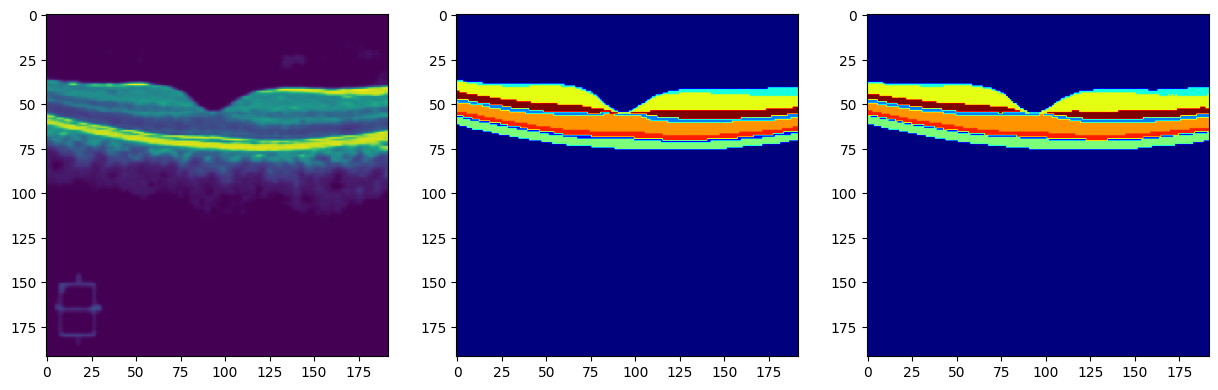

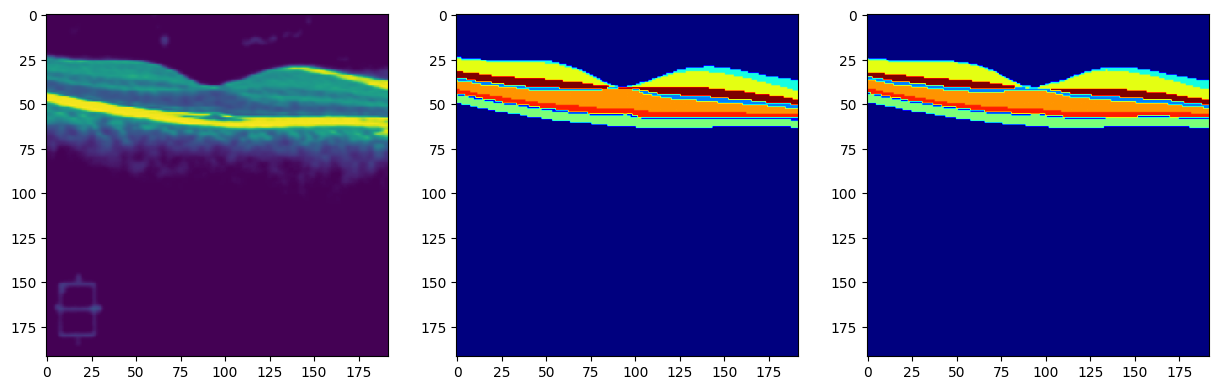

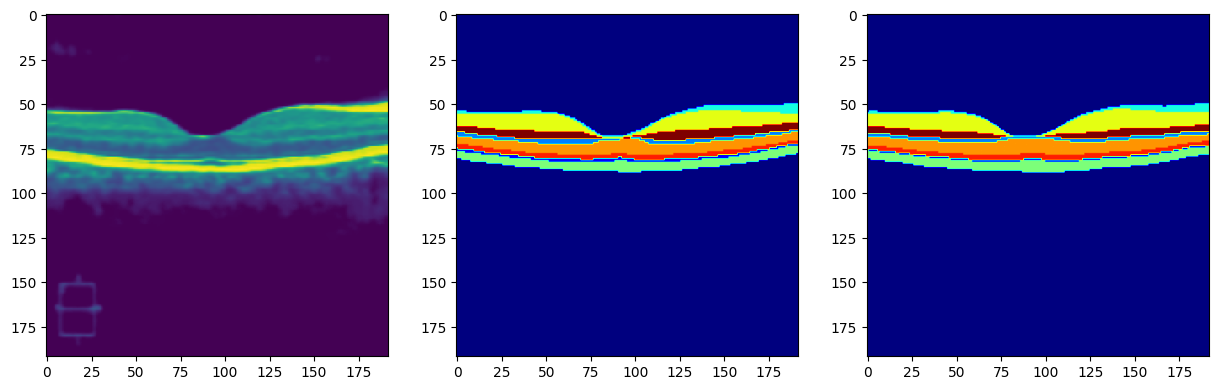

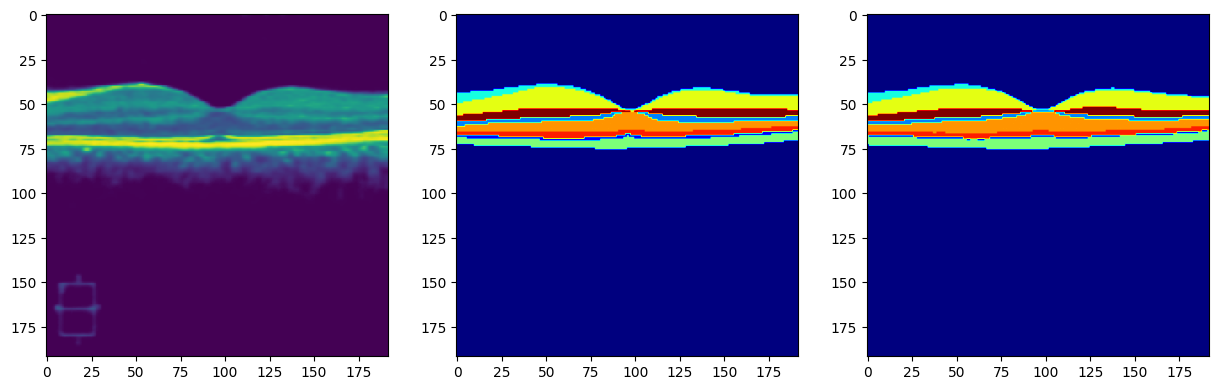

In [27]:
i=0
for img, org, msk in zip(imgs, original, pred):
#     print(org.shape,msk.shape)
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1,3,2)
#     plt.imshow(org,cmap="jet")
#     plt.subplot(1,3,2)
    plt.imshow(org,cmap="jet")
    plt.subplot(1,3,3)
    plt.imshow(msk,cmap="jet")
    plt.show()
    i+=1
    if i==5:
        break

In [38]:
os.makedirs("x_img", exist_ok=True)
os.makedirs("y_img", exist_ok=True)
os.makedirs("y_pred_img", exist_ok=True)
i=0
for img, org, msk in zip(imgs, original, pred):
    plt.figure(figsize=(15, 5))
    plt.imshow(img)
    plt.savefig("x_img/"+str(i)+".png")
    plt.clf()
    plt.imshow(org,cmap="jet")
    plt.savefig("y_img/"+str(i)+".png")
    plt.clf()
    plt.imshow(msk,cmap="jet")
    plt.savefig("y_pred_img/"+str(i)+".png")
    plt.clf()
    i+=1

/tmp/ipykernel_36/4178652711.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 5))


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>